In [1]:
import os
import numpy as np
import pandas as pd

from itertools import product
from collections import defaultdict

import itertools

import mlflow
from mlflow import MlflowClient
from mlflow.entities import ViewType

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

import mpl_toolkits.axisartist as axisartist
# import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick
from matplotlib.colors import PowerNorm

from matplotlib.colors import ListedColormap

# %matplotlib widget
%matplotlib inline

os.environ['MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR'] = 'False'
matplotlib.rcParams['font.family'] = 'monospace'

In [2]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


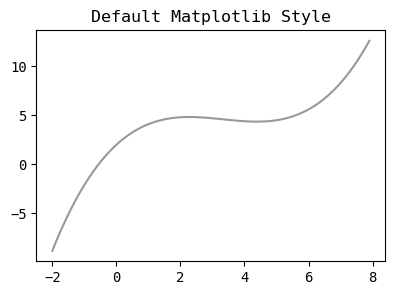

In [3]:
colors=list()
with plt.style.context("grayscale"):
    for i, color in enumerate(plt.rcParams['axes.prop_cycle']):
        # if i == 4:
        #     continue
        colors.append(color['color'])

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-2, 8, .1)
y = .1 * x ** 3 - x ** 2 + 3 * x + 2

fig, ax = plt.subplots(figsize=(4.5, 3), dpi=100)
ax.plot(x, y, color=colors[2])
ax.set_title('Default Matplotlib Style');



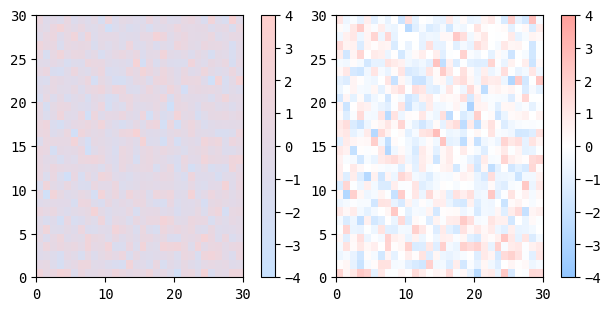

In [4]:
colors = list()
# with plt.style.context("default"):
with plt.style.context("seaborn-v0_8-pastel"):
    for i, color in enumerate(plt.rcParams['axes.prop_cycle']):
        if i == 4:
            continue
        colors.append(color['color'])

        # if len(colors) == 4:
        #     break

with plt.style.context("grayscale"):
    for i, color in enumerate(plt.rcParams['axes.prop_cycle']):
        if i < 2:
            continue
        colors.append(color['color'])
i, j = 1, 0
i, j = 2, 0
d = 256

v = np.ones((d, 4))
for ch in range(3):
    v[:, ch] = np.linspace(1, matplotlib.colors.to_rgb(colors[i])[ch], d)/2 \
               + np.linspace(matplotlib.colors.to_rgb(colors[j])[ch], 1, d)/2
seq_cmap = ListedColormap(v)

d = 128
v_up = np.ones((d, 4))
v_bot = np.ones((d, 4))
for ch in range(3):
    v_up[:, ch] = np.linspace(matplotlib.colors.to_rgb(colors[j])[ch], 1, d)
    v_bot[:, ch] = np.linspace(1, matplotlib.colors.to_rgb(colors[i])[ch], d)
div_cmap = ListedColormap(np.vstack((v_up, v_bot)))


def plot_examples(colormaps):
    np.random.seed(0)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()


plot_examples([seq_cmap, div_cmap])

In [5]:
class FirstElementHashable(tuple):
    def __eq__(self, comp):
        return self[0] == comp[0]

    def __ne__(self, comp):
        return self[0] != comp[0]

    def __hash__(self):
        return hash((self[0],))

class HashableDict(dict):
    def __eq__(self, comp):
        return self['id'] == comp['id']

    def __ne__(self, comp):
        return self['id'] != comp['id']

    def __hash__(self):
        return hash(self['id'])

def params_dict_to_string(d):
    st = list()
    for k, v in d.items():
        if k in ['loss', 'dataset']:
            continue
        if isinstance(v, str):
            v = eval(v)
            st.append(f"{k}={v['name']}")
        elif isinstance(v, dict):
            st.append(f"{k}={v['name']}")
        else:
            if k[-1] == "_":
                k = k[:-1]
            v = str(v)#.replace('{', '(').replace('}', ')')
            st.append(f"{k}={v}")

    st = ' '.join(st)
    st = st.replace('_', '')
    return st


def title_from_dict(d):
    st = list()
    for k, v in d.items():
        # if k not in ya_keys:
        #     continue

        # if k[-1] == '_':
        #     k = k[:-1]

        if isinstance(v, str):
            v = eval(v)
            st.append(f"{k}={v['name']}")
        elif isinstance(v, dict):
            st.append(f"{k}={v['name']}")
        elif isinstance(v, set):
            # print(v)
            for i in v:
                if i is not None:
                    break
            # v = str(i).replace('{', '(').replace('}', ')')
            st.append(f"{k}={i}")
        else:
            st.append(f"{k}={str(v)}")

    st = ' '.join(st)
    st = st.replace('_', '')
    return st

In [6]:
tracking_uri = os.path.expanduser('~/mlruns/')
experiment_name = os.path.basename(os.getcwd())
# experiment_name = 'GPU'

In [7]:
markers = ['^', '<', '>', 'v', 'o', 'd', 's', '*']

In [8]:
#  finals for resnet
# query = 'params.model="ResNet18" and params.valenabled="True" and tags."about" = "single thread / 300 cut test / 3 of 10 classes"'
query = 'params.model="ResNet18" and params.valenabled="True"'
query = 'params.model="ResNet18" and params.valenabled="False"'
# query = 'params.valenabled="False" and tags."about" = "single thread / 300 cut test / 3 of 10 classes"'

#  finals for bert
# query = 'params.model="BERT"'
query = 'params.valenabled="True" and params.model="BERT"'
# query = 'params.valenabled_="False" and params.model="BERT"'

query = None

if query is None:
    raise ValueError('Chose one of the above lines to plot corresponding experiments')

    


label_keys = ['optimizer', 'mdfull_', 'trueweights']
same_plot = ['seed', 'nepochs', 'weights', 'mdniters_', 'valenabled_']  # , 'mdlr_'
ya_keys = ['hratio']
# ya_keys = []

client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          # filter_string=query,
                          filter_string=query,
                          run_view_type=ViewType.ACTIVE_ONLY)
configs = list()
ya_keys_set = set()  # contains parameters which can be None for some runs
id_lookup_set = set()
for r in runs:
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json', )
    configs.append(config)

    for k in config:
        v = config[k]
        if isinstance(v, dict):
            v = HashableDict(v)
            config[k] = v
            configs[-1][k] = v

        if k[-1] == '_' and k not in label_keys and k not in same_plot:
            ya_keys_set.add(k)

        d = dict()
        for k in label_keys: #  or k in same_plot:
            d.update({k: v})
        id_lookup_set.add(str(d))

id_lookup_list = list(id_lookup_set)
ya_keys += list(ya_keys_set)
ya_keys
params_set = set()
sparse_configs = list()

for i, r in enumerate(runs):
    config = configs[i]

    sparse_cfg = dict()
    for k, v in config.items():
        if k in label_keys or k in ya_keys or k in same_plot:
            continue
        sparse_cfg.update({k: v})
    params_set.add(str(sparse_cfg))
    sparse_configs.append(sparse_cfg)

params_set

{"{'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'BERT', 'id': 5}, 'dataset': {'name': 'GoEmotions', 'id': 4}, 'valenabled': True, 'valnsamples': None, 'nclasses': 28, 'batchsize': 40, 'lr': 0.01}"}

In [9]:
params_list = list(params_set)
ya_dicts_list = [set() for _ in params_set]
for i, r in enumerate(runs):
    config = configs[i]
    sparse_config = sparse_configs[i]
    i = params_list.index(str(sparse_config))

    d = dict()
    for k in ya_keys:
        if k not in same_plot:# and k not in label_keys:
            d.update({k: config[k]})
    ya_dicts_list[i].add(str(d))

In [10]:
ya_dicts_list

[{"{'hratio': 0.5, 'mdlr_': 0.1, 'mdbatchsize_': 30}",
  "{'hratio': 0.5, 'mdlr_': None, 'mdbatchsize_': 30}",
  "{'hratio': 0.5, 'mdlr_': None, 'mdbatchsize_': None}",
  "{'hratio': 0.7, 'mdlr_': 0.1, 'mdbatchsize_': 30}",
  "{'hratio': 0.7, 'mdlr_': None, 'mdbatchsize_': 30}",
  "{'hratio': 0.7, 'mdlr_': None, 'mdbatchsize_': None}",
  "{'hratio': 0.9, 'mdlr_': 0.1, 'mdbatchsize_': 30}",
  "{'hratio': 0.9, 'mdlr_': None, 'mdbatchsize_': 30}",
  "{'hratio': 0.9, 'mdlr_': None, 'mdbatchsize_': None}",
  "{'hratio': 0.99, 'mdlr_': 0.1, 'mdbatchsize_': 30}",
  "{'hratio': 0.99, 'mdlr_': None, 'mdbatchsize_': 30}",
  "{'hratio': 0.99, 'mdlr_': None, 'mdbatchsize_': None}",
  "{'hratio': None, 'mdlr_': None, 'mdbatchsize_': None}"}]

In [11]:
ya_dicts_list[0]

{"{'hratio': 0.5, 'mdlr_': 0.1, 'mdbatchsize_': 30}",
 "{'hratio': 0.5, 'mdlr_': None, 'mdbatchsize_': 30}",
 "{'hratio': 0.5, 'mdlr_': None, 'mdbatchsize_': None}",
 "{'hratio': 0.7, 'mdlr_': 0.1, 'mdbatchsize_': 30}",
 "{'hratio': 0.7, 'mdlr_': None, 'mdbatchsize_': 30}",
 "{'hratio': 0.7, 'mdlr_': None, 'mdbatchsize_': None}",
 "{'hratio': 0.9, 'mdlr_': 0.1, 'mdbatchsize_': 30}",
 "{'hratio': 0.9, 'mdlr_': None, 'mdbatchsize_': 30}",
 "{'hratio': 0.9, 'mdlr_': None, 'mdbatchsize_': None}",
 "{'hratio': 0.99, 'mdlr_': 0.1, 'mdbatchsize_': 30}",
 "{'hratio': 0.99, 'mdlr_': None, 'mdbatchsize_': 30}",
 "{'hratio': 0.99, 'mdlr_': None, 'mdbatchsize_': None}",
 "{'hratio': None, 'mdlr_': None, 'mdbatchsize_': None}"}

In [12]:
# dicts = ya_dicts_list[0]

# d_out = defaultdict(set)
# for d in dicts:
#     for k, v in _eval(d).items():
#         if v is not None:
#             d_out[k].add(v)
    

In [13]:


# for i in product_dict(**d_out):
#     print(f"{i=}")

In [14]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

        
def _eval(d):
    d = eval(d)
    for k in d.keys():
        if isinstance(v, str):
            d[k] = eval(d[k])
    return d

In [15]:
params_lists = list()
for p in params_set:
    d = _eval(p)
    params_lists.append([d.copy()])

runs_sets_lists = [[set()] for _ in params_lists]
for j, params_list in enumerate(params_lists):
    ya_dicts = [_eval(d) for d in sorted(ya_dicts_list[j])]

    ya_sparse = defaultdict(set)
    for d in ya_dicts:
        for k, v in d.items():
            if v is not None:
                ya_sparse[k].add(v)


    for d in product_dict(**ya_sparse):
        print(f"{d.values()=}")
        # if None in set(d.values()):
        #     continue
        d.update(params_list[0])
        params_list.append(d.copy())
        runs_sets_lists[j].append(set())
        print(f"{runs_sets_lists[j]=}")

print(f"{len(runs_sets_lists)=}")

d.values()=dict_values([0.5, 0.1, 30])
runs_sets_lists[j]=[set(), set()]
d.values()=dict_values([0.7, 0.1, 30])
runs_sets_lists[j]=[set(), set(), set()]
d.values()=dict_values([0.99, 0.1, 30])
runs_sets_lists[j]=[set(), set(), set(), set()]
d.values()=dict_values([0.9, 0.1, 30])
runs_sets_lists[j]=[set(), set(), set(), set(), set()]
len(runs_sets_lists)=1


In [16]:
def params_in_config(params, config, sparse=False):
    for k in params:
        if k not in ya_keys and config[k] != params[k]:
            return False

    for k in ya_keys:
        # if config[k] is not None and ((k in params and config[k] != params[k])):
        if config[k] is not None and ((k in params and config[k] != params[k]) or sparse):
            return False
    return True
# def params_in_config_sparse(params, config):
#     for k in params:
#         if config[k] != params[k]:
#             return False
    
    
#     for k in ya_keys:
#         if config[k] is not None:
#             return False
        
#     return True


# def params_in_config_not_sparse(params, config):
#     for k in params:
#         if k not in ya_keys and config[k] != params[k]:
#             return False
    
#     # count_none = 0
#     # cou
#     for k in ya_keys:
#         if config[k] is not None and config[k] != params[k]:
#             return False
        
#     return True

# def params_in_config(params, config, sparse=False):
#     if sparse:
#         return params_in_config_sparse(params, config)
#     else:
#         return params_in_config_not_sparse(params, config)
        
#     for k in params:
#         if k not in ya_keys and config[k] != params[k]:
#             return False

#     for k in ya_keys:
#         # if config[k] is not None and ((k in params and config[k] != params[k])):
#         if config[k] is not None and ((k in params and config[k] != params[k]) or sparse):
#             return False
#     return True

sparse_extended = [False for _ in params_lists]
for i, r in enumerate(runs):
    config = configs[i]

    for j, params_list in enumerate(params_lists):
        for t, params in enumerate(params_list):
            if params_in_config(params_list[t], config, not t):
                runs_sets_lists[j][t].add(FirstElementHashable((r, config)))
                if t:
                    sparse_extended[j] = True

In [17]:
sparse_extended

[True]

In [18]:
labels = set()
for r in runs:
    labels.add(r.info.run_name)

labels = list(labels)
labels.sort()
lookup_id_dict = {v: i for i, v in enumerate(labels)}

def iterate_run_sets():
    for j, params_list in enumerate(params_lists):
        if sparse_extended[j] is False:
            yield params_list[0], runs_sets_lists[j][0]
        else:
            for i, params in enumerate(params_list):
                if i and len(runs_sets_lists[j][i]):
                    yield params, runs_sets_lists[j][i].copy().union(runs_sets_lists[j][0].copy())

In [19]:
lookup_id_dict = {'TAWT': 0,
 'SGD Ideal': 4,
 'SGD Full': 5,
 'MeritFed SMD': 2,
 'MeritFed MD': 3,
 'FedFomo': 6,
 'FedAdp': 1}

params={'hratio': 0.5, 'mdlr_': 0.1, 'mdbatchsize_': 30, 'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'BERT', 'id': 5}, 'dataset': {'name': 'GoEmotions', 'id': 4}, 'valenabled': True, 'valnsamples': None, 'nclasses': 28, 'batchsize': 40, 'lr': 0.01}

name='test-loss hratio=0.5 mdlr=0.1 mdbatchsize=30 npeers=20 model=BERT valenabled=True valnsamples=None nclasses=28 batchsize=40 lr=0.01'
len(name)=131
params={'hratio': 0.7, 'mdlr_': 0.1, 'mdbatchsize_': 30, 'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'BERT', 'id': 5}, 'dataset': {'name': 'GoEmotions', 'id': 4}, 'valenabled': True, 'valnsamples': None, 'nclasses': 28, 'batchsize': 40, 'lr': 0.01}

name='test-loss hratio=0.7 mdlr=0.1 mdbatchsize=30 npeers=20 model=BERT valenabled=True valnsamples=None nclasses=28 batchsize=40 lr=0.01'
len(name)=131
params={'hratio': 0.99, 'mdlr_': 0.1, 'mdbatchsize_': 30, 'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'mode

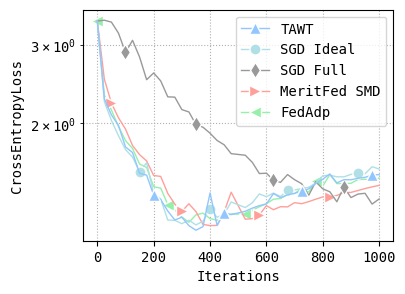

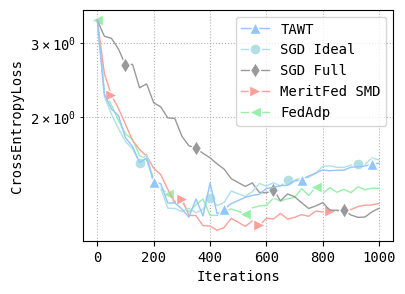

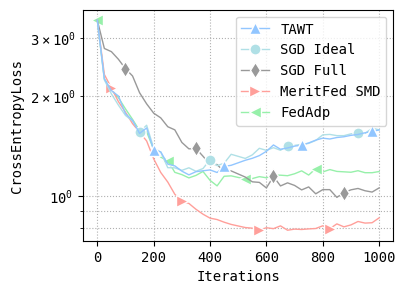

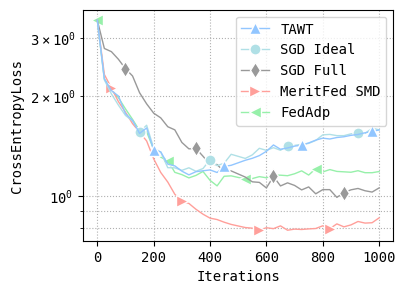

In [20]:
beg = 0
end = 20000
metric_key = 'train-loss'
metric_key = 'test-loss'
# metric_key = 'test-accuracy'
# metric_key = 'expected-loss'
for i, (params, runs) in enumerate(iterate_run_sets()):
    print(f"{params=}")
    print()
    if len(runs) < 2:
        continue

    title = params_dict_to_string(params)
    # fig, ax = plt.subplots(figsize=(8, 6))
    fig, ax = plt.subplots(figsize=(4, 3))
    df = list()
    for j, (r, config) in enumerate(runs):
        label = r.info.run_name
        id = lookup_id_dict[label]
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        history = [dict(e, **{'label': r.info.run_name}, **{'seed': config['seed']}) for e in history]
        # history = [dict(e, **{'label': r.info.run_name}, **{'seed': 0}) for e in history]
        df.append(pd.DataFrame.from_dict(history))
    df = pd.concat(df).reset_index(drop=True)
    df = df.drop('timestamp', axis=1)

    for j, (label, g) in enumerate(df.groupby(["label"])):
        id = lookup_id_dict[label[0]]
        meancov = list()
        for i, m in g.groupby(['step'], group_keys=True):
            # if i[0] > 800:
            #     continue
            m = m.drop('label', axis=1)
            m = m.drop('key', axis=1)
            m = m.drop('seed', axis=1)
            tmp = m.mean(numeric_only=True).to_frame().transpose().rename(columns={"value": 'm'})
            m = m.drop('step', axis=1)
            # tmp = tmp.join(m.cov(numeric_only=True).reset_index(drop=True).rename(columns={'value': 'c'}))
            meancov.append(tmp)

        meancov = pd.concat(meancov, axis=0)
        ax.plot(meancov.step, meancov.m,  alpha=1, label=label[0], color=colors[id],
                marker=markers[id],
                markevery=slice(2*j, len(meancov.step), 10),
                markersize=8, linewidth=1,
                markeredgecolor='white', markeredgewidth=1)
        # if label[0] != 'TAWT':
        # plt.fill_between(meancov.step, meancov.m - meancov.c**0.5, meancov.m + meancov.c**0.5,color=colors[id], alpha=0.3)

    # ax.set_title(metric_key + ' ' + title, fontsize=7)
    ax.set_yscale('log')
    
    ax.grid(True, which="both", ls='dotted')
    loc = ax.yaxis.get_minor_locator()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
    ax.legend(handles, labels)
    # ax.legend(loc='center right')

    ax.set_xlabel('Iterations')
    # ax.set_xscale('log')

    ax.set_ylabel(params['loss']['name'])

    # locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
    # locmin = matplotlib.ticker.LogLocator(base=10.0, subs=[i/10 for i in range(0,10)], numticks=100)
    # ax.yaxis.set_minor_locator(locmin)
    # ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    

    name = metric_key + ' ' + title
    print(f"{name=}")
    print(f"{len(name)=}")
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    
    # plt.tight_layout()
    fig.show()

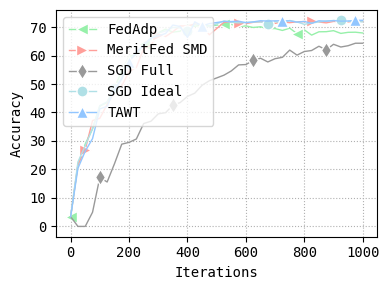

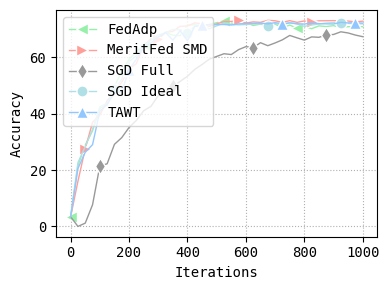

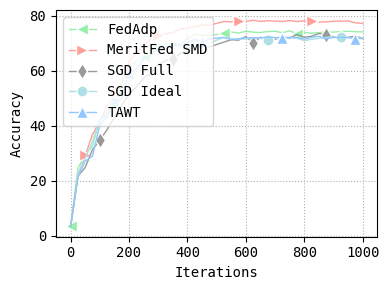

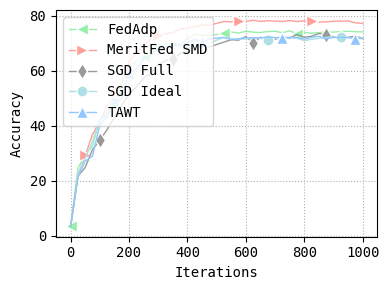

In [21]:
beg = 500
beg = 0
end = 20000
metric_key = 'test-accuracy'
# metric_key = 'train-accuracy'
for i, (params, runs) in enumerate(iterate_run_sets()):
    if len(runs) < 3:
        continue
    # print(f"{params=}")
    # print(f"{i=}")
    # print()

    # if i == 0:
    #     continue

    title = params_dict_to_string(params)
    # fig, ax = plt.subplots(figsize=(8, 6))
    fig, ax = plt.subplots(figsize=(4, 3))
    df = list()
    for j, (r, config) in enumerate(runs):
        label = r.info.run_name
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        history = [dict(e, **{'label': r.info.run_name}, **{'seed': config['seed']}) for e in history]
        # history = [dict(e, **{'label': r.info.run_name}, **{'seed': 0}) for e in history]
        df.append(pd.DataFrame.from_dict(history))
    df = pd.concat(df).reset_index(drop=True)
    df = df.drop('timestamp', axis=1)

    for j, (label, g) in enumerate(df.groupby(["label"])):
        id = lookup_id_dict[label[0]]
        # for _, s in g.groupby(['seed'], group_keys=False):
        #     ax.plot(s.step, s.value,  alpha=0.4, color=colors[id], linewidth=1)
        #     # break

        meancov = list()
        for i, m in g.groupby(['step'], group_keys=True):
            # if i[0] > 800:
            #     continue
            m = m.drop('label', axis=1)
            m = m.drop('key', axis=1)
            m = m.drop('seed', axis=1)

            tmp = m.mean(numeric_only=True).to_frame().transpose().rename(columns={"value": 'm'})

            m = m.drop('step', axis=1)
            # tmp = tmp.join(m.cov(numeric_only=True).reset_index(drop=True).rename(columns={'value': 'c'}))
            meancov.append(tmp)

        meancov = pd.concat(meancov, axis=0)
        ax.plot(meancov.step, meancov.m,  alpha=1, label=label[0], color=colors[id],
                marker=markers[id],
                markevery=slice(2*j, len(meancov.step), 10),
                markersize=8, linewidth=1,
                markeredgecolor='white', markeredgewidth=1)
        # plt.fill_between(meancov.step, meancov.m - meancov.c**0.5, meancov.m + meancov.c**0.5,color=colors[id], alpha=0.3)
        # break

    # ax.set_title(metric_key + ' ' + title, fontsize=7)
    ax.grid(True, which="both", ls='dotted')
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
    # ax.legend(handles, labels)
    ax.legend(loc='upper left')

    ax.set_xlabel('Iterations')
    # ax.set_xscale('log')

    ax.set_ylabel('Accuracy')
    # ax.set_yscale('log')

    name = metric_key + ' ' + title
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    plt.tight_layout()
    fig.show()

In [22]:
from matplotlib import ticker

40
params={'hratio': 0.5, 'mdlr_': 0.1, 'mdbatchsize_': 30, 'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'BERT', 'id': 5}, 'dataset': {'name': 'GoEmotions', 'id': 4}, 'valenabled': True, 'valnsamples': None, 'nclasses': 28, 'batchsize': 40, 'lr': 0.01}

ticks_map=array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39])
40
params={'hratio': 0.7, 'mdlr_': 0.1, 'mdbatchsize_': 30, 'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'BERT', 'id': 5}, 'dataset': {'name': 'GoEmotions', 'id': 4}, 'valenabled': True, 'valnsamples': None, 'nclasses': 28, 'batchsize': 40, 'lr': 0.01}

ticks_map=array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39])
40
params={'hratio': 0.99, 'mdlr_': 0.1, 'mdbatchsize_': 30, 'npeers': 20, 'loss': {'name': 'CrossEntropyLoss', 'id': 1}, 'model': {'name': 'BERT', 'id': 5}, 'dataset': {'name': 'GoEmotions', 'id': 4}, 'valenabled'

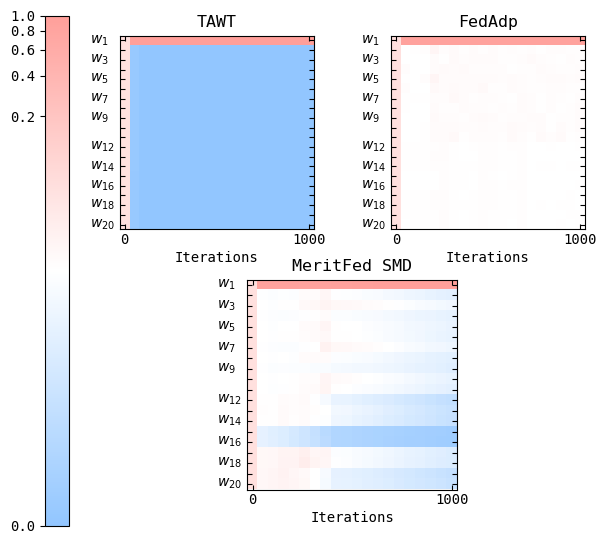

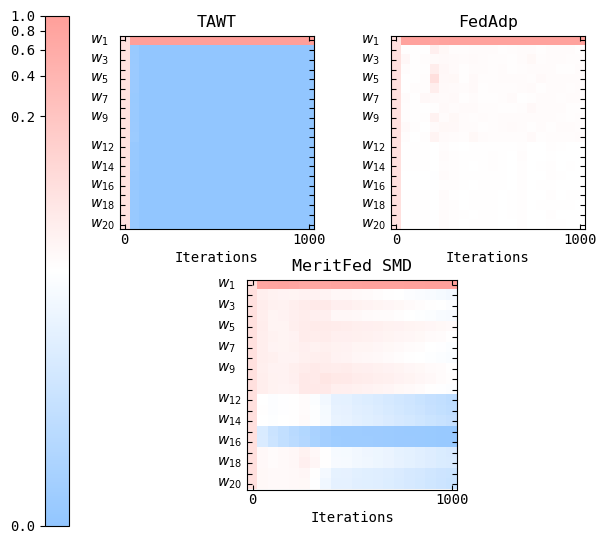

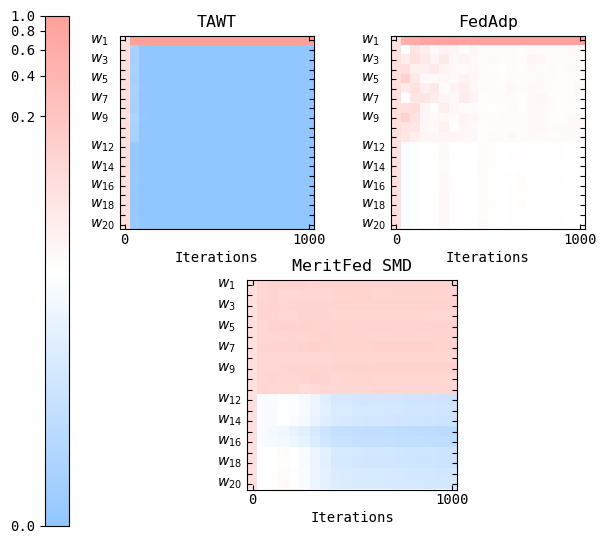

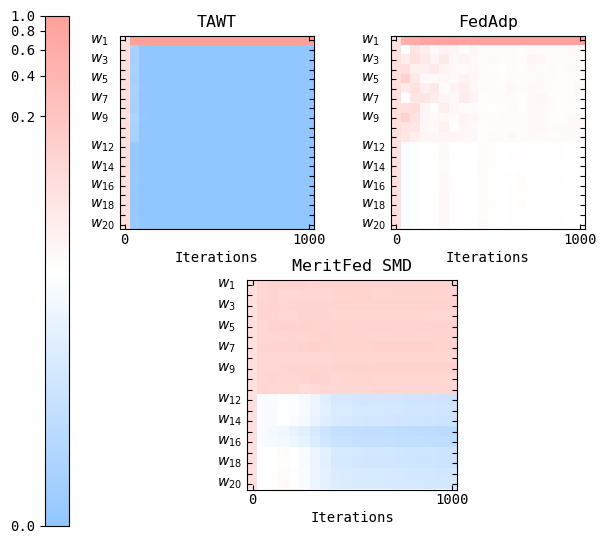

In [24]:

for i, (params, runs) in enumerate(iterate_run_sets()):
    if len(runs) < 3:
        continue
    min_w, max_w = 1., 0.
    weights = list()
    names = set()

    for j, (r, config) in enumerate(runs):
        # if config['mdniters_'] is not None:
        if config['mdniters_'] is not None or r.info.run_name == 'TAWT' or r.info.run_name == 'FedAdp':
            names.add(r.info.run_name)
            for rank in range(config['npeers']):
                k = 'weights_%s' % (str(rank))
                history = client.get_metric_history(run_id=r.info.run_id, key=k)#[:end]
                y = np.array([h.value for h in history])
                # print(f"{length=}")
                length = len(y)
                weights.append(y.min())
                weights.append(y.max())
    weights = np.array(weights)
    min_w = min(min_w, weights.min())
    max_w = max(max_w, weights.max())

    # fig = plt.figure(figsize=(4, 2))
    axs = list()
    
    end=40
    end=length
    print(end)
    
    #  for no val
    # fig = plt.figure(figsize=(3, 8))
    # gs = GridSpec(ncols=1, nrows=len(names))
    # for j in range(len(names)):
    #     axs.append(fig.add_subplot(gs[j, 0], axes_class=axisartist.Axes))
    # fig.subplots_adjust(hspace=0.4)
    

    # fig = plt.figure(figsize=(8, 2))
    # gs = GridSpec(nrows=1, ncols=len(names))
    # for j in range(len(names)):
    #     axs.append(fig.add_subplot(gs[0, j], axes_class=axisartist.Axes))

    # fig = plt.figure(figsize=(6, 6))
    # gs = GridSpec(nrows=2, ncols=2)
    # for i in range(2):
    #     for j in range(2):
    #         axs.append(fig.add_subplot(gs[i, j], axes_class=axisartist.Axes))
    # fig.subplots_adjust(wspace=.4)

    fig = plt.figure(figsize=(6, 6))
    gs = GridSpec(nrows=2, ncols=2)
    for i in range(2):
        if not i:
            for j in range(2):
                axs.append(fig.add_subplot(gs[i, j], axes_class=axisartist.Axes))
        else:
            axs.append(fig.add_subplot(gs[i, 0:2], axes_class=axisartist.Axes))
    fig.subplots_adjust(wspace=.4)
    

    print(f"{params=}")
    print()
    title = params_dict_to_string(params)
    df = list()
    for j, (r, config) in enumerate(runs):
        if not (config['mdniters_'] is not None or r.info.run_name == 'TAWT' or r.info.run_name == 'FedAdp'):
            continue
        labels = list()
        y_ticks_map = np.linspace(0, config['npeers']-1, 10, endpoint=True).round().astype(int)
        for rank in range(config['npeers']):
            k = 'weights_%s' % (str(rank))
            if rank in y_ticks_map:
                labels.append(r'$  w_{%s}$' % (str(rank+1)))
            else:
                labels.append('')

            label = r.info.run_name
            history = client.get_metric_history(run_id=r.info.run_id, key=k)#[:end]
            history = [dict(e, **{'label': r.info.run_name}, **{'seed': config['seed']}) for e in history]
            df.append(pd.DataFrame.from_dict(history))
    df = pd.concat(df).reset_index(drop=True)
    df = df.drop('timestamp', axis=1)

    x = list()
    ticks_map = np.linspace(0, end-1, config['npeers'], endpoint=True).round().astype(int)
    print(f"{ticks_map=}")
    for _, (label, g) in enumerate(df.groupby(["label"], group_keys=True)):
        tmp2 = list()
        for key, k in g.groupby(['key']):
            tmp = list()
            
            jj=0
            for j, (step, s) in enumerate(k.groupby(['step'])):
                if j not in ticks_map:
                    continue
                jj+=1
                x.append(step[0])
                # print(step[0])
                # x.append(jj)
                s = s.drop('label', axis=1)
                s = s.drop('key', axis=1)
                s = s.drop('seed', axis=1).reset_index(drop=True)
                s = s.mean()
                tmp.append(s)
            tmp = pd.concat(tmp, axis=1).transpose().rename(columns={'value': key[0]})#.reset_index(drop=True)
            tmp2.append(tmp)

        dfs = [df.set_index('step') for df in tmp2]
        dfs = pd.concat(dfs, axis=1)

        weights = list()
        for rank in range(config['npeers']):
            k = 'weights_%s' % (str(rank))
            weights.append(dfs[k].tolist())
        id = lookup_id_dict[label[0]]
        axs[id].set_title(label[0])
        # im = axs[id].matshow(weights, cmap=div_cmap, norm=PowerNorm(gamma=1. / 4., vmin=min_w, vmax=max_w))
        im = axs[id].matshow(weights, cmap=div_cmap, norm=PowerNorm(gamma=1. / 7.3, vmin=min_w, vmax=max_w))
        axs[id].set_xlabel('Iterations')
        axs[id].set_xticks([0, len(ticks_map)-1])
        axs[id].set_xticklabels(['0', str(x[-1])])

        axs[id].axis["left"].major_ticklabels.set_ha("left")
        axs[id].set_yticks(np.arange(len(labels)), labels=labels)

    cbar_ax = fig.add_axes([0., 0.05, .04, 0.85])
    # cbar_ax = fig.add_axes([0., 0.05, .02, 0.85])
    cb = fig.colorbar(im, cax=cbar_ax, location='left', format=mtick.FormatStrFormatter('%.1f'))
    # fig.subplots_adjust(wspace=.4)
    # fig.subplots_adjust(wspace=.1, hspace=0.3)

    name = 'w' + ' ' + title
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    fig.show()
    # break